# Using Natural Language Processing to Classify Literary Genres
# Brian Mann

In [503]:
# imported libraries
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
import numpy as np
import os
import pandas as pd
import re
import requests
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import string
from textblob import TextBlob
from wordcloud import WordCloud

## Scraping Data from Project Gutenberg

In [4]:
# define useful global variables
shelf_stem = 'https://www.gutenberg.org/ebooks/bookshelf/'
directory_stem = '/Users/alexmann/Documents/Datas/Books/'
shelves = ['82', '36', '42', '44']
genres = ['Adventure', 'Fantasy', 'Horror', 'Humor']

In [5]:
# this function takes in a url for Project Gutenberg (PG) and a genre
# it makes a request to the site, grabs the text file, and saves it under the folder for that genre
def download_book(url, genre):
    # get the response and find the plain text file in the htlm
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    link = soup.find('a', string="Plain Text UTF-8")
    # if the link exists, write the content to a txt file
    if link:
        txt_file = text_url = 'https://www.gutenberg.org' + link['href']
        txt_response = requests.get(txt_file)
        # find the header which contains the title and author
        title = soup.find('h1').text.strip()
        path = os.path.join(directory_stem + genre, f'{title}.txt')
        # save the contents to the file
        with open(path, 'wb') as f:
            f.write(txt_response.content)
        print(f"Downloaded: {title}")
    else:
        print(f'No link found for {url}')

In [14]:
# this function takes in a shelf number and genre name
# the shelf number indicates which genre to search for on PG
# for every book that is found in this search, all of the available txt files are downloaded to the os
def visit_links(shelf, genre):
    # search through the first 50 novels
    exts = ['', '?start_index=26']
    # for all the first 50 novels, save as many txt files that exist to the os
    for ex in exts:
        response = requests.get(shelf_stem + shelf + ex)
        soup = BeautifulSoup(response.content, 'html.parser')
        books = soup.find_all('li', class_ = 'booklink')
        for book in books:
            link = book.find('a', class_ = 'link')
            url = 'https://www.gutenberg.org' + link['href']
            download_book(url, genre)

In [16]:
# download all the four genres onto the user's system
for shelf, genre in zip(shelves, genres):
    visit_links(shelf, genre)

Downloaded: Twenty years after by Alexandre Dumas and Auguste Maquet
Downloaded: The Count of Monte Cristo by Alexandre Dumas and Auguste Maquet
Downloaded: The call of the wild by Jack London
Downloaded: Around the World in Eighty Days by Jules Verne
Downloaded: White Fang by Jack London
Downloaded: The three musketeers by Alexandre Dumas and Auguste Maquet
Downloaded: Kidnapped by Robert Louis Stevenson
Downloaded: The Scarlet Pimpernel by Baroness Emmuska Orczy Orczy
Downloaded: Moby-Dick; or, The Whale by Herman Melville
Downloaded: Kim by Rudyard Kipling
Downloaded: Tarzan of the Apes by Edgar Rice Burroughs
Downloaded: King Solomon's Mines by H. Rider Haggard
Downloaded: The Thirty-Nine Steps by John Buchan
Downloaded: Scaramouche: A Romance of the French Revolution by Rafael Sabatini
Downloaded: She by H. Rider Haggard
Downloaded: The Man in the Iron Mask by Alexandre Dumas
Downloaded: Captain Blood by Rafael Sabatini
Downloaded: The Prisoner of Zenda by Anthony Hope
No link fou

Downloaded: The Tale of Terror: A Study of the Gothic Romance by Edith Birkhead
Downloaded: The Damned by Algernon Blackwood
Downloaded: The Lost Stradivarius by John Meade Falkner
Downloaded: The Sorcery Club by Elliott O'Donnell
Downloaded: Infernaliana by Charles Nodier
Downloaded: Three Men in a Boat (To Say Nothing of the Dog) by Jerome K. Jerome
Downloaded: The Devil's Dictionary by Ambrose Bierce
Downloaded: Right Ho, Jeeves by P. G. Wodehouse
Downloaded: Nonsense Books by Edward Lear
Downloaded: Three men on the bummel by Jerome K. Jerome
Downloaded: My Man Jeeves by P. G. Wodehouse
Downloaded: The Wit and Humor of America, Volume X (of X) by Marshall P. Wilder
Downloaded: The New Pun Book by Thomas A. Brown and T. J. Carey
Downloaded: The Book of Nonsense by Edward Lear
Downloaded: The Man with Two Left Feet, and Other Stories by P. G. Wodehouse
Downloaded: Mr. Punch's Golf Stories by J. A. Hammerton
Downloaded: Comic History of the United States by Bill Nye
No link found for 

## Extracting Only Each Book's Text

Note: This is all due to the fact that Project Gutenberg adds their own text descriptions at the beginning and end of each book. 

In [33]:
# this function takes in a txt file for a given novel
# it then rewrites the txt file to remove the bits auto-generated by the PG website outside of the novel itself
def extract_novel(file):
    # define the tags that indicate the start and end of the actual novel's text
    start = '*** START OF THE PROJECT'
    end = '*** END OF THE PROJECT'
    try:
        with open(file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
        
        s_idx = e_idx = -1
        # if the lines exist in the file, find the indices
        for i, line in enumerate(lines):
            if start in line:
                s_idx = i
            elif end in line:
                e_idx = i
                break
        # if both the indices exist, extract the text between only those indices
        if s_idx != -1 and e_idx != -1:
            extracted_list = lines[s_idx+1:e_idx]
            extracted_txt = ''.join(extracted_list).strip()
            # write the contents to the same txt file
            with open(file, 'w', encoding='utf-8') as new_f:
                new_f.write(extracted_txt)
        else:
            print(f'Could not find markers in {file}')
    except Exception as e:
        print(f'Failed to edit file {file}: {e}')

In [39]:
# this function takes in a genre folder, then extracts only the novel's text from all the files in that folder
def clean_novel_files(genre):
    path = directory_stem + genre
    # for each of the files, extract the novel text
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        # avoid the .DS_Store file that is automatically placed into Mac folders
        if os.path.isfile(file_path) and file != '.DS_Store':
            extract_novel(file_path)

In [41]:
# extract all of the novels' text
for genre in genres:
    clean_novel_files(genre)

## Initializing a DataFrame Containing Book Information

In [46]:
# this function initializes the novel info dataframe and returns it
def generate_dataframe():
    # this regex is used for extracting the title and author from the text file's name
    rgx = r'^(.*?) by (.*?)\.txt$'
    # initialize a list of dictionaries
    data = []
    # iterate over each of the folders in the directory
    for genre in genres:
        path = directory_stem + genre
        # for each file, match the regex, then add the corresponding info to the data list 
        for file in os.listdir(path):
            if file.endswith('.txt'):
                matching = re.match(rgx, file)
                if matching:
                    title, author = matching.group(1), matching.group(2)
                    data.append({
                        'title': title, 'author': author, 'filename': file, 'genre': genre
                    })
    # generate a dataframe from the list of dictionaries
    return pd.DataFrame(data)      

In [47]:
# generate the dataframe
bookdf = generate_dataframe()

In [50]:
# ensure that there are 25 of each of the genres
# (previously, files were deleted by hand so that each genre had an even amount of files)
bookdf.genre.value_counts()

genre
Adventure    25
Horror       25
Humor        25
Fantasy      24
Name: count, dtype: int64

There is a missing novel. This is because it does not actually have an official author, so the author could not be extracted properly from the title. We will now manually add this files information to the dataframe and add the subsequent row via concatenation. 

In [55]:
# add the missing author as 'Anonymous' and concatenate the subsequent dataframes
missingbook = 'The Story of the Volsungs (Volsunga Saga); with Excerpts from the Poetic Edda.txt'
new_row = pd.DataFrame({'title': ['The Story of the Volsungs (Volsunga Saga); with Excerpts from the Poetic Edda'], 
           'author': ['Anonymous'], 
           'filename': ['The Story of the Volsungs (Volsunga Saga); with Excerpts from the Poetic Edda.txt'], 
           'genre': ['Fantasy']})
new_df = pd.concat([bookdf, new_row], ignore_index=True)
# verify that it worked
new_df.tail()

,title,author,filename,genre
95,Something New,P. G. Wodehouse,Something New by P. G. Wodehouse.txt,Humor
96,"'Oh, Well, You Know How Women Are!'",Irvin S. Cobb and Mary Roberts Rinehart,"'Oh, Well, You Know How Women Are!' by Irvin S...",Humor
97,The Book of Nonsense,Edward Lear,The Book of Nonsense by Edward Lear.txt,Humor
98,Piccadilly Jim,P. G. Wodehouse,Piccadilly Jim by P. G. Wodehouse.txt,Humor
99,The Story of the Volsungs (Volsunga Saga); wit...,Anonymous,The Story of the Volsungs (Volsunga Saga); wit...,Fantasy


In [56]:
# set our original df to the new df
bookdf = new_df

Additionally, there was one repeated novel, since it happened to be shared amongst two different genres. This novel was then removed and replaced in the horror genre by a different novel. 

In [75]:
# replace the duplicate novel with a novel that was manually downloaded
bookdf.iloc[62, :] = ['The House of the Vampire', 'George Sylvester Viereck', 'The House of the Vampire by George Sylvester Viereck.txt', 'Horror']

In [78]:
# verify there are 100 unique novels
len(bookdf.title.unique())

100

In [81]:
bookdf.head()

,title,author,filename,genre
0,El Dorado: An Adventure of the Scarlet Pimpernel,Baroness Emmuska Orczy Orczy,El Dorado: An Adventure of the Scarlet Pimpern...,Adventure
1,The Prisoner of Zenda,Anthony Hope,The Prisoner of Zenda by Anthony Hope.txt,Adventure
2,Ten Years Later,Alexandre Dumas,Ten Years Later by Alexandre Dumas.txt,Adventure
3,King Solomon's Mines,H. Rider Haggard,King Solomon's Mines by H. Rider Haggard.txt,Adventure
4,Child of Storm,H. Rider Haggard,Child of Storm by H. Rider Haggard.txt,Adventure


In [80]:
bookdf.describe()

,title,author,filename,genre
count,100,100,100,100
unique,100,55,100,4
top,El Dorado: An Adventure of the Scarlet Pimpernel,P. G. Wodehouse,El Dorado: An Adventure of the Scarlet Pimpern...,Adventure
freq,1,9,1,25


## Word Frequency Analysis

A list of the most common 25,000 English words was downloaded from Kaggle. But for ease of use in future analysis, it will benefit us to get rid of all the stop words from this file, as we will only be concerned with extracting words of significant meaning for our frequency analysis. 

In [86]:
# initialize the data path and set of stop words
data_path = '/Users/alexmann/Documents/Datas/'
stop_words = set(stopwords.words('english'))
# open the text file for the common English words and set the text equal to a variable
with open(data_path + 'common_words.txt', 'r') as f:
    lines = f.readlines()
# remove stop words from the file and rewrite it
with open(data_path + 'common_words_no_filler.txt', 'wt') as f:
    for line in lines:
        word = line.strip()
        if word not in stop_words:
            f.write(word + '\n')

In [87]:
# add all of the distinct words from the file to a set called 'meaningful_words'
meaningful_words = set()
with open(data_path + 'common_words_no_filler.txt', 'r') as f:
    for line in f.readlines():
        word = line.strip()
        meaningful_words.add(word)

In [89]:
# find the total number of meaningful words
len(meaningful_words)

25194

** Note, there were a few hundred more than 25,000 words to begin with, so after removing stop words, this numbers tracks. 

In [111]:
# this function takes in a file, reads the text, then returns a dictionary of each meaningful word with 
# its word count
def word_frequency(file):
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    # tokenize the text and find the significant words
    words = word_tokenize(text.lower())
    significant_words = [word for word in words if word in meaningful_words]
    # return the counter dictionary
    return dict(Counter(significant_words))

In [117]:
# this function takes in a frequency dictionary, then filters out only the keys over 6 letters and returns the 
# resulting dictionary
def long_word_frequency(freqs):
    long_words = dict()
    for word, f in freqs.items():
        if len(word) > 5:
            long_words[word] = f
    return long_words

In [122]:
# this function takes in a limit 'n' and a word frequency dictionary
# it returns the top n words sorted by frequency
def get_top(n, freqs):
    return sorted(freqs.items(), key=lambda x: -x[1])[:n]

In [112]:
# this function generates a word cloud from a given word frequency dictionary
def generate_word_cloud(freqs):
    cloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freqs)
    plt.figure(figsize=(10, 5))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [113]:
# this function takes in two word frequency dictionaries and returns their union, with 
# the sum of word frequencies between the two dictionaries added to each word
def combine_dict(dct1, dct2):
    for word, freq in dct1.items():
        if word in dct2:
            dct2[word] += freq
        else:
            dct2[word] = freq
    return dct2

In [114]:
# this function takes a given genre, then it returns the total combined word frequencies across every 
# novel in the genre's folder
def genre_word_frequency(genre):
    words_dict = dict()
    # go through each txt file in the directory, combining all of the word frequency dictionaries together
    for file in os.listdir(directory_stem + genre):
        if file.endswith('.txt'):
            path = os.path.join(directory_stem + genre, file)
            words = word_frequency(path)
            words_dict = combine_dict(words, words_dict)
    return words_dict

In [119]:
freq_list = list()
# create a list of the word frequency dictionaries for each genre
for genre in genres:
    freq_list.append(genre_word_frequency(genre))

In [137]:
long_freq_list = list()
# create a frequency dictionary list of only the longer words (6+ letters)
for freq in freq_list:
    long_freq_list.append(long_word_frequency(freq))

In [138]:
# this function takes in a limit n and a list of word frequency dictionaries
# it returns a list of dictionaries that filters out only the top words not shared by any of the 
# other word frequency dictionaries for item in the list
# e.g. if the word 'apple' is shared by the genres Horror and Humor, it will be filtered out of both 
# word frequency dictionaries
def filter_top_words(n, freqs):
    # intialize the list of top word freq dicts, and a filtered list
    top = list()
    other_top_words = list()
    # generate the top 'n' words frequency dictionary for each of the dictionaries in the freqs list
    for freq in freqs:
        top.append(dict(get_top(n, freq)))
    # for each of these dictionaries, filter out the top words that are shared among a given genre 
    # and any of the other genres
    for i, dct in enumerate(top):
        # create a list of the other dictionaries that does not include the current one
        other_dicts = top[0:i] + top[i+1:]
        # get a set of the top words, and a dictionary for the filtered words
        top_words = set()
        filtered_words = dict()
        # add each of the top words from the other dictionaries to the 'top_words' set
        for other_dict in other_dicts:
            for other_word in other_dict:
                top_words.add(other_word)
        # if the word in our current dictionary is not among the 'top_words' set, add it to our filtered words
        for word, freq in dct.items():
            if word not in top_words:
                filtered_words[word] = freq
        other_top_words.append(filtered_words)
    # return the list of the filtered dictionaries
    return other_top_words

In [144]:
# set the limit to 300
number_wanted = 300
# filter out the top shared words, then create an additional list that filters out shorter words
top_words = filter_top_words(number_wanted, freq_list)
top_long_words = filter_top_words(number_wanted // 2, long_freq_list)

Word Cloud for Adventure Books


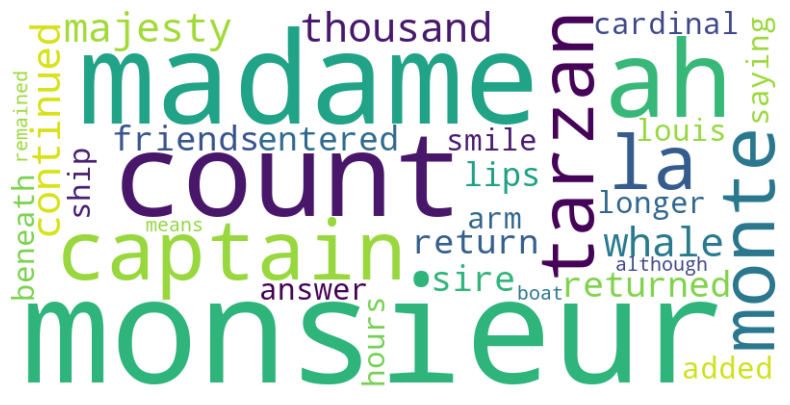

Word Cloud for Fantasy Books


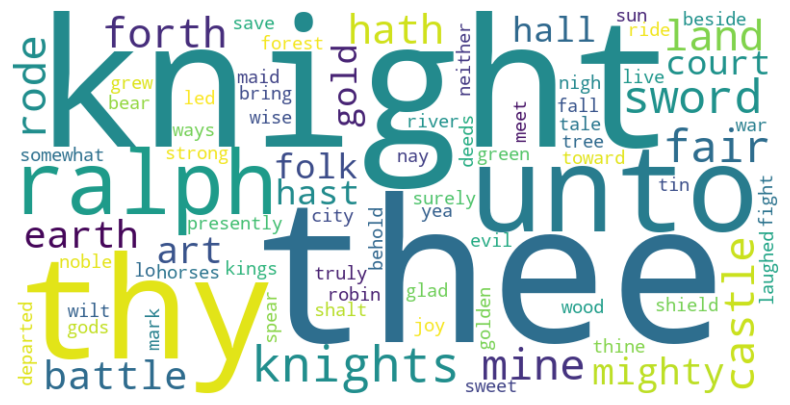

Word Cloud for Horror Books


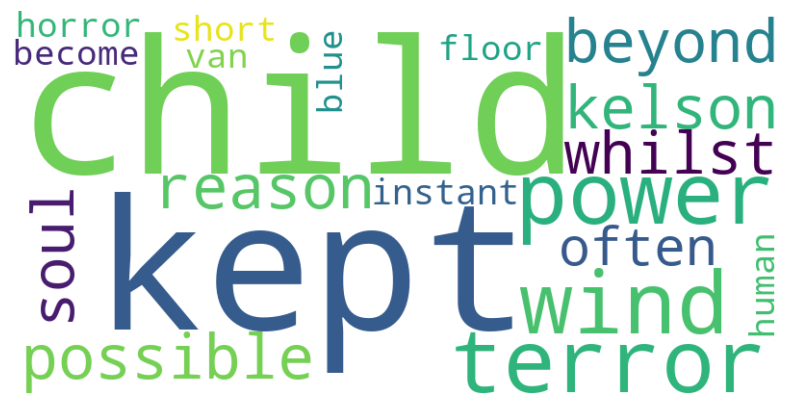

Word Cloud for Humor Books


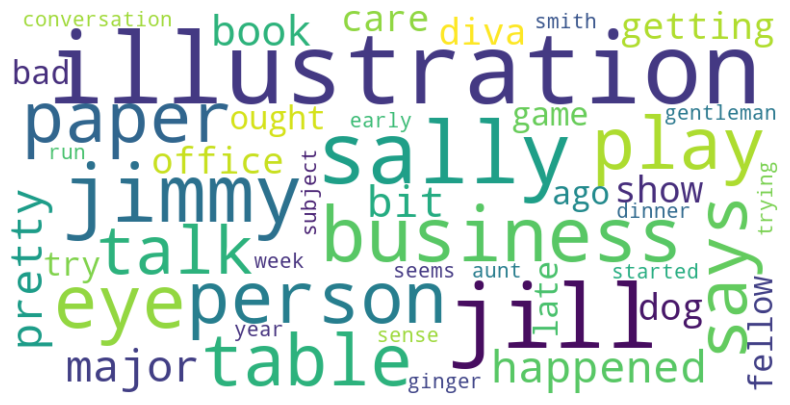

In [146]:
# print the word frequency cloud for each genre
for freq, genre in zip(top_words, genres):
    print(f'Word Cloud for {genre} Books')
    generate_word_cloud(freq)

Word Cloud for Adventure Books (>5 letters)


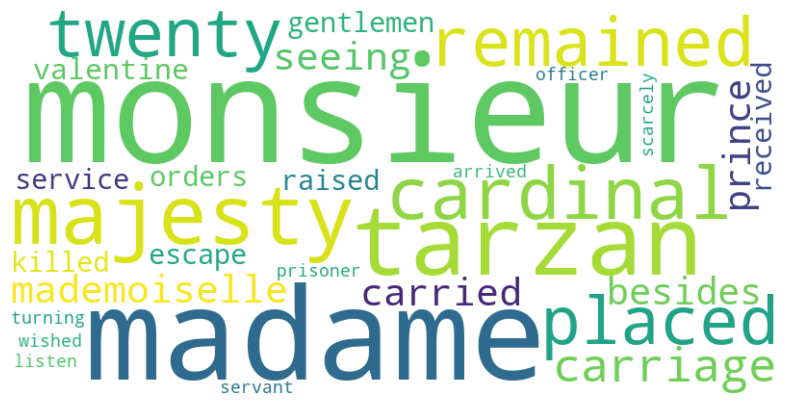

Word Cloud for Fantasy Books (>5 letters)


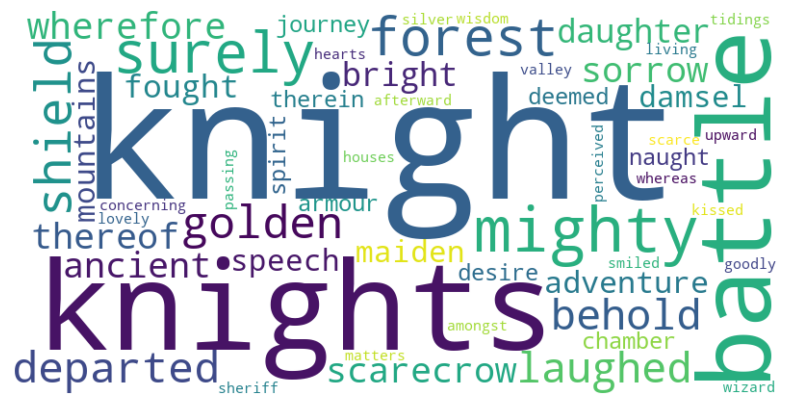

Word Cloud for Horror Books (>5 letters)


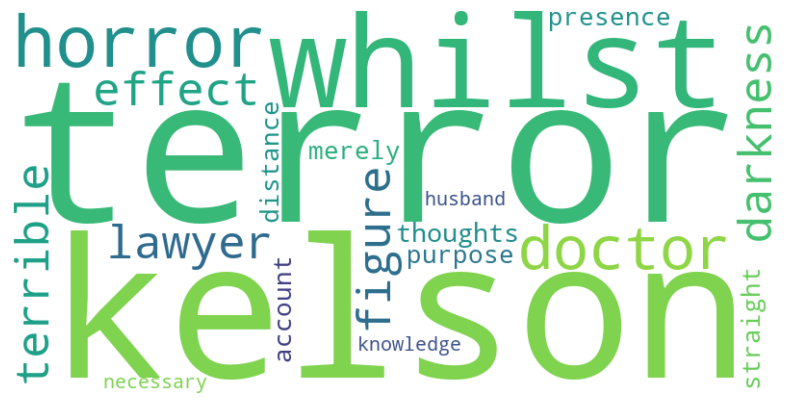

Word Cloud for Humor Books (>5 letters)


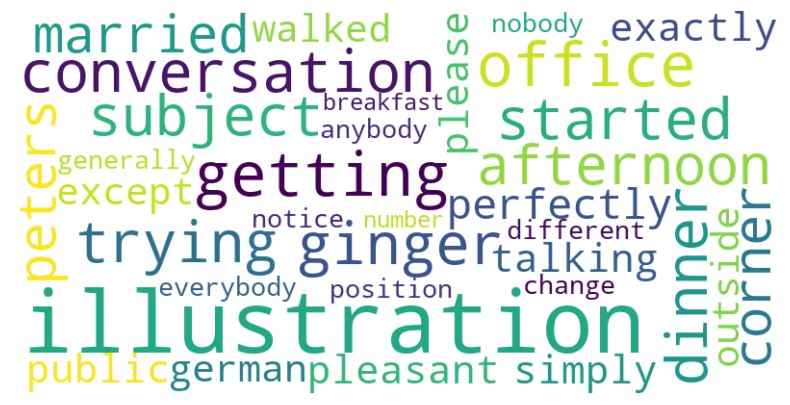

In [149]:
# print the word frequency cloud for each genre, filtering out any words <5 letters
for freq, genre in zip(top_long_words, genres):
    print(f'Word Cloud for {genre} Books (>5 letters)')
    generate_word_cloud(freq)

## Complexity Analysis

In [160]:
# this function takes in a text file
# it then generates various different complexity statistics, and returns the contents as a dictionary
def complexity_measures(file):
    # read the novel's text
    with open(file, 'r') as f:
        text = f.read()
    # get a list of all the alphabetical words
    words = nltk.word_tokenize(text)
    words = [word.lower() for word in words if word.isalpha()]
    # calculate word count, page count, and average word length
    word_count = len(words)
    page_count = word_count // 300
    avg_word_length = sum(len(word) for word in words) / word_count
    # find the set of unique words, and use it to generate the number of unique words and the 
    # vocab diversity
    unique_words = set(words)
    vocab_size = len(unique_words)
    vocab_diversity = vocab_size / word_count
    # find the number of 'difficult words' containing a synset of size less than or equal to 2
    num_difficult = 0
    for word in unique_words:
        syn = wordnet.synsets(word)
        if syn:
            if len(syn) <= 2:
                num_difficult += 1
        else:
            num_difficult += 1
    difficulty_score = num_difficult / vocab_size
    # return a dictionary containing all of these calculated statistics
    return {
        'word_count': word_count,
        'page_count': page_count, 
        'avg_word_length': avg_word_length,
        'vocab_size': vocab_size,
        'vocab_diversity': vocab_diversity,
        'difficulty_score': difficulty_score
    }

In [165]:
# generate a list of each of the word complexity dictionaries for each row of the dataframe
complexity_list = list()
for _, row in bookdf.iterrows():
    f, g = row.filename, row.genre
    measures = complexity_measures(directory_stem + g + '/' + f)
    # add the filename as an identifier for each of the dictionaries
    measures['filename'] = f
    complexity_list.append(measures)

In [167]:
# convert the list of dictionaries into a dataframe
complexity_df = pd.DataFrame(complexity_list)

In [169]:
# merge the two dataframes on the 'filename' key
bookdf2 = pd.merge(bookdf, complexity_df, on='filename')

In [171]:
bookdf2.head()

,title,author,filename,genre,word_count,page_count,avg_word_length,vocab_size,vocab_diversity,difficulty_score
0,El Dorado: An Adventure of the Scarlet Pimpernel,Baroness Emmuska Orczy Orczy,El Dorado: An Adventure of the Scarlet Pimpern...,Adventure,122493,408,4.294531,8416,0.068706,0.384625
1,The Prisoner of Zenda,Anthony Hope,The Prisoner of Zenda by Anthony Hope.txt,Adventure,54287,180,3.948588,4987,0.091864,0.300983
2,Ten Years Later,Alexandre Dumas,Ten Years Later by Alexandre Dumas.txt,Adventure,183577,611,4.334372,9335,0.050851,0.372576
3,King Solomon's Mines,H. Rider Haggard,King Solomon's Mines by H. Rider Haggard.txt,Adventure,81336,271,4.103324,6843,0.084132,0.329095
4,Child of Storm,H. Rider Haggard,Child of Storm by H. Rider Haggard.txt,Adventure,92554,308,4.008925,5926,0.064027,0.312184


In [172]:
bookdf2.describe()

,word_count,page_count,avg_word_length,vocab_size,vocab_diversity,difficulty_score
count,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000
mean,76985.230000,256.13000,4.180777,6012.030000,0.108843,0.350434
std,63419.280419,211.39573,0.178899,2681.233323,0.058068,0.049589
min,3271.000000,10.00000,3.817406,912.000000,0.028142,0.248266
25%,33635.250000,111.75000,4.068152,4152.000000,0.073040,0.315189
50%,66059.000000,219.50000,4.156107,5790.500000,0.095512,0.345126
75%,97818.250000,325.75000,4.296845,7485.250000,0.129259,0.381438
max,450827.000000,1502.00000,4.748128,16493.000000,0.329662,0.498026


In [294]:
# this function generates an array of histograms given a dataframe, a list of columns, 
# and optional options for rows, columns and figure size
def basic_histograms(df, cols, nrows=1, ncols=1, figsize=(12,12)):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    # flatten the axis for ease of entry
    ax = ax.flatten()
    # generate histograms for each of the columns
    for idx, col in enumerate(cols):
        sns.histplot(df, x=col, color='#8ACF8F', ax=ax[idx])
        ax[idx].set_title(f'Histogram of {col}')
    # delete unused figures
    for i in range(len(cols), len(ax)):
        fig.delaxes(ax[i])
    plt.tight_layout()
    plt.show()

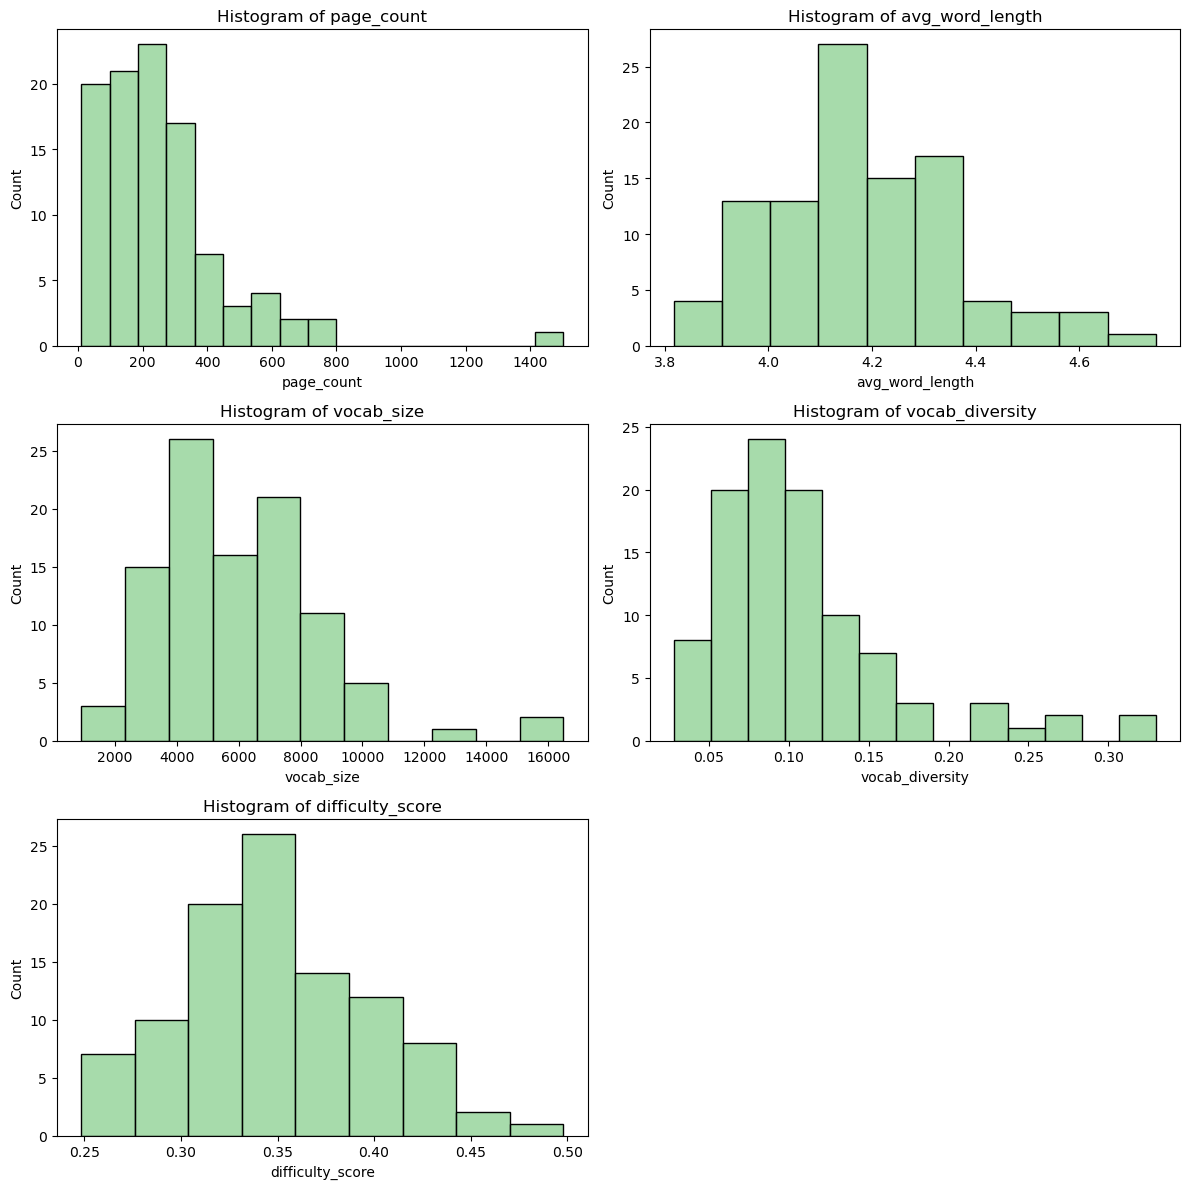

In [213]:
basic_histograms(bookdf2, bookdf2.columns[5:], 3, 2)

In [295]:
# this function does the same as the basic_histograms function, but grouped and colored by a 'grouper' 
def grouped_histograms(df, cols, grouper, nrows=1, ncols=1, figsize=(12,12)):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    ax = ax.flatten()
    for idx, col in enumerate(cols):
        sns.histplot(df, x=col, hue=grouper, palette='Set1', ax=ax[idx])
        ax[idx].set_title(f'Histogram of {col} Grouped by {grouper}')
    for i in range(len(cols), len(ax)):
        fig.delaxes(ax[i])
    plt.tight_layout()
    plt.show()

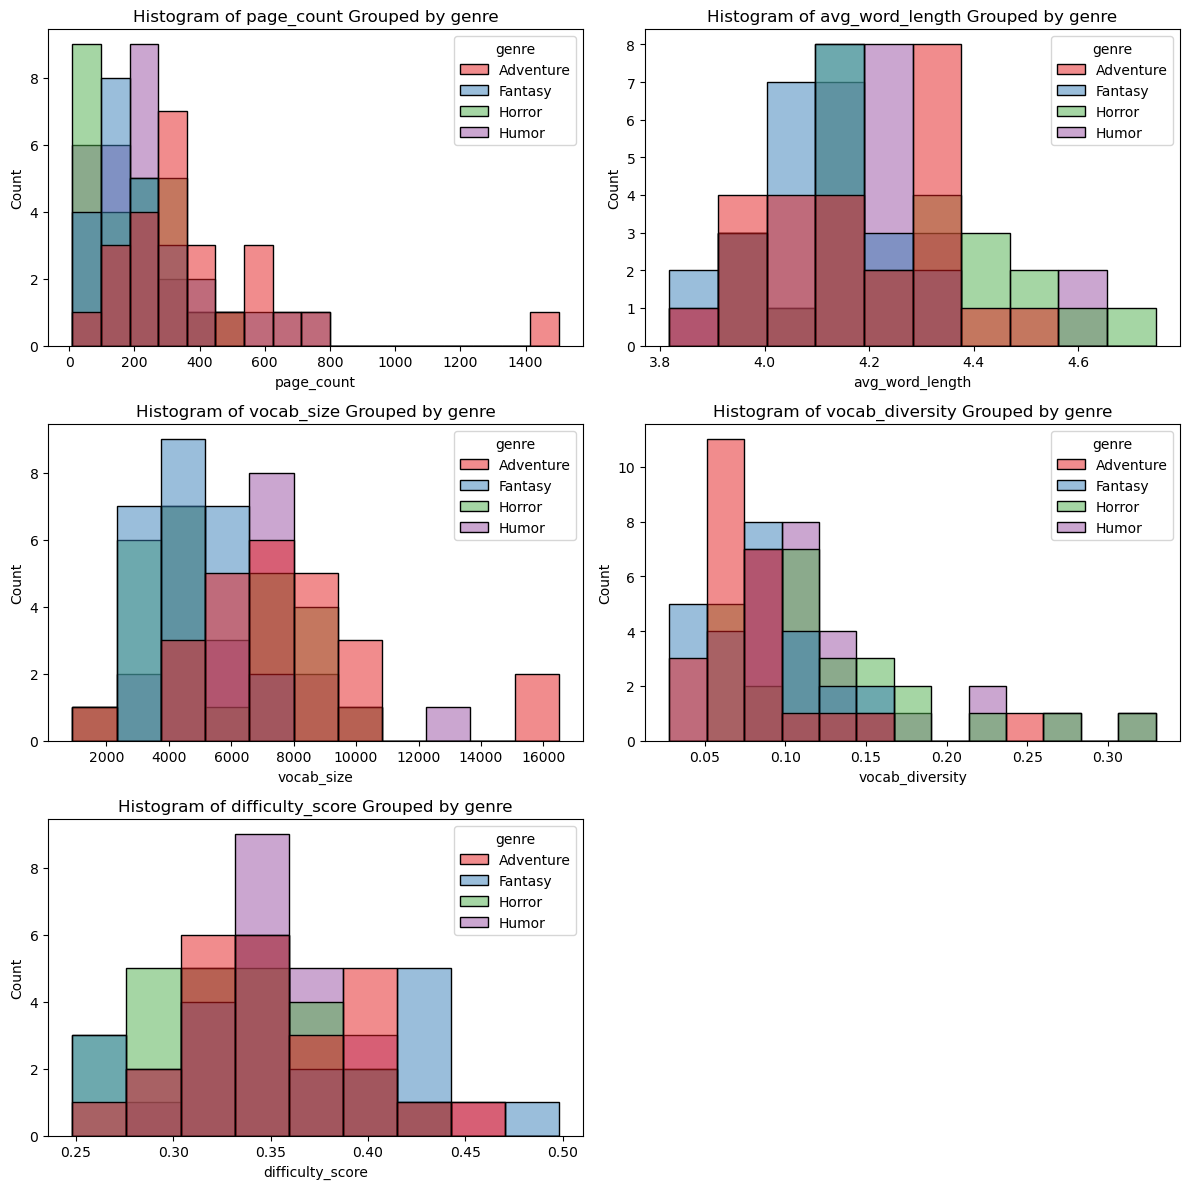

In [215]:
grouped_histograms(bookdf2, bookdf2.columns[5:], 'genre', 3, 2)

In [296]:
# this function takes in a dataframe, list of columns, a grouper, and optional entries for 
# rows, columns, and figure size
# it then prints out barplots of the median values for each of the columns, colored by the 'grouper' 
def median_barplots(df, cols, grouper, nrows=1, ncols=1, figsize=(12,12)):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    ax = ax.flatten()
    # generate each of the barplots for the given columns
    for idx, col in enumerate(cols):
        meds = df.groupby(grouper)[col].median()
        sns.barplot(x=meds.index, y=meds.values, palette='Set1', ax=ax[idx])
        ax[idx].set_title(f'Barplot of Median {col} by {grouper}')
    # delete unused plots
    for i in range(len(cols), len(ax)):
        fig.delaxes(ax[i])
    plt.tight_layout()
    plt.show()

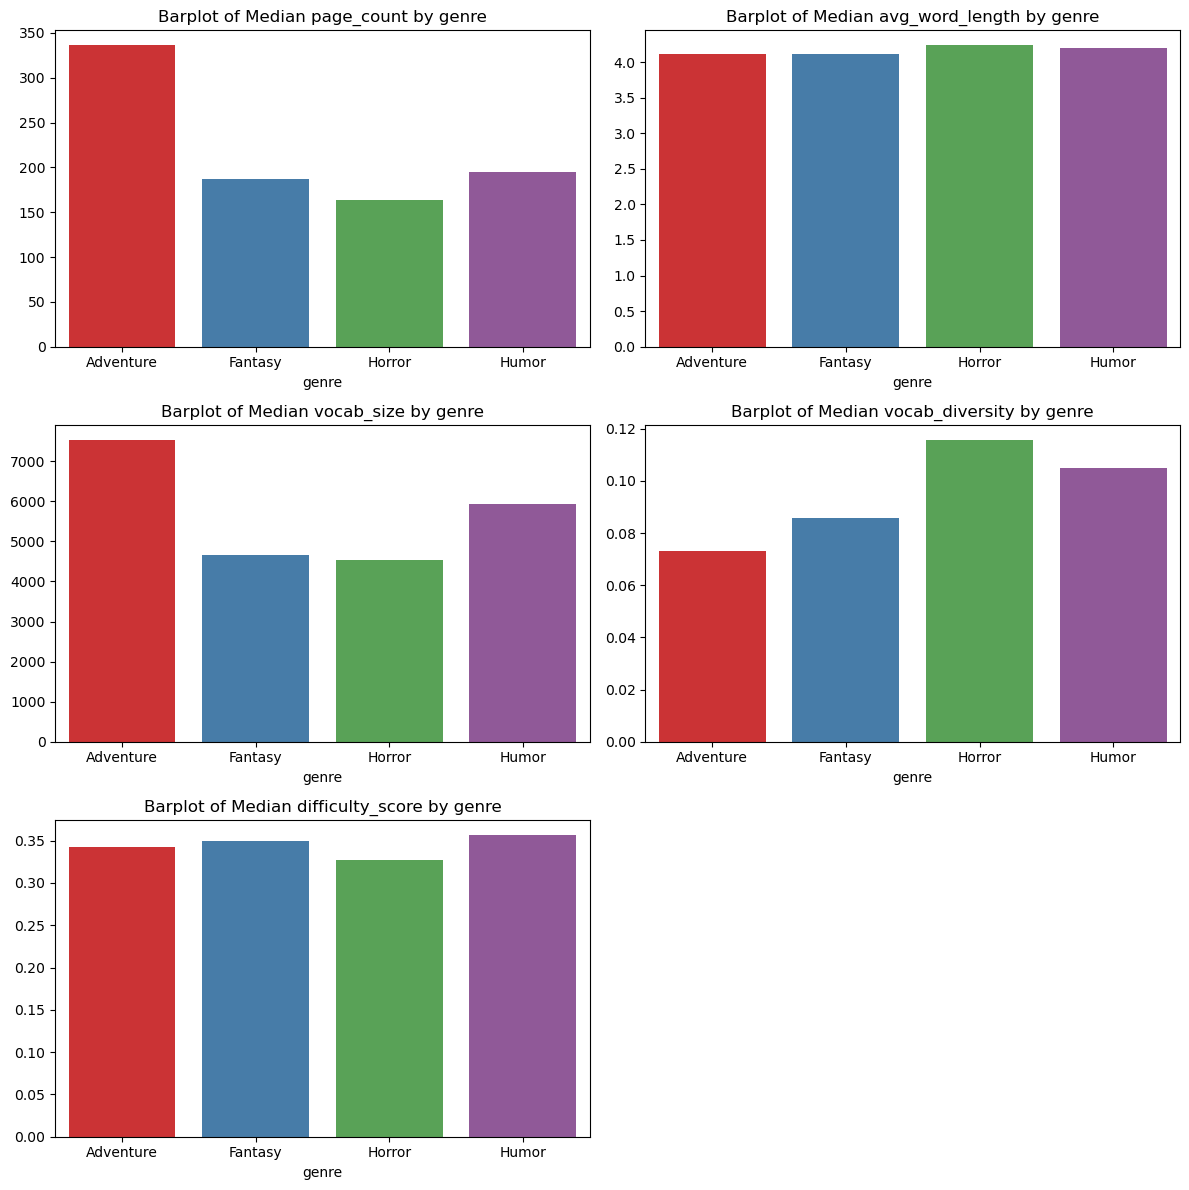

In [223]:
median_barplots(bookdf2, bookdf2.columns[5:], 'genre', 3, 2)

In [297]:
# this function does the same thing as the median_barplots function, but instead of calculating the median
# it generates a boxplot colored by the given 'grouper'
def boxplots(df, cols, grouper, nrows=1, ncols=1, figsize=(12,12)):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    ax = ax.flatten()
    # generate each of the barplots for the given columns    
    for idx, col in enumerate(cols):
        sns.boxplot(data=df, x=grouper, y=col, palette='Set1', ax=ax[idx])
        ax[idx].set_title(f'Boxplot of {col} Grouped by {grouper}')
    # delete unused plots
    for i in range(len(cols), len(ax)):
        fig.delaxes(ax[i])
    plt.tight_layout()
    plt.show()

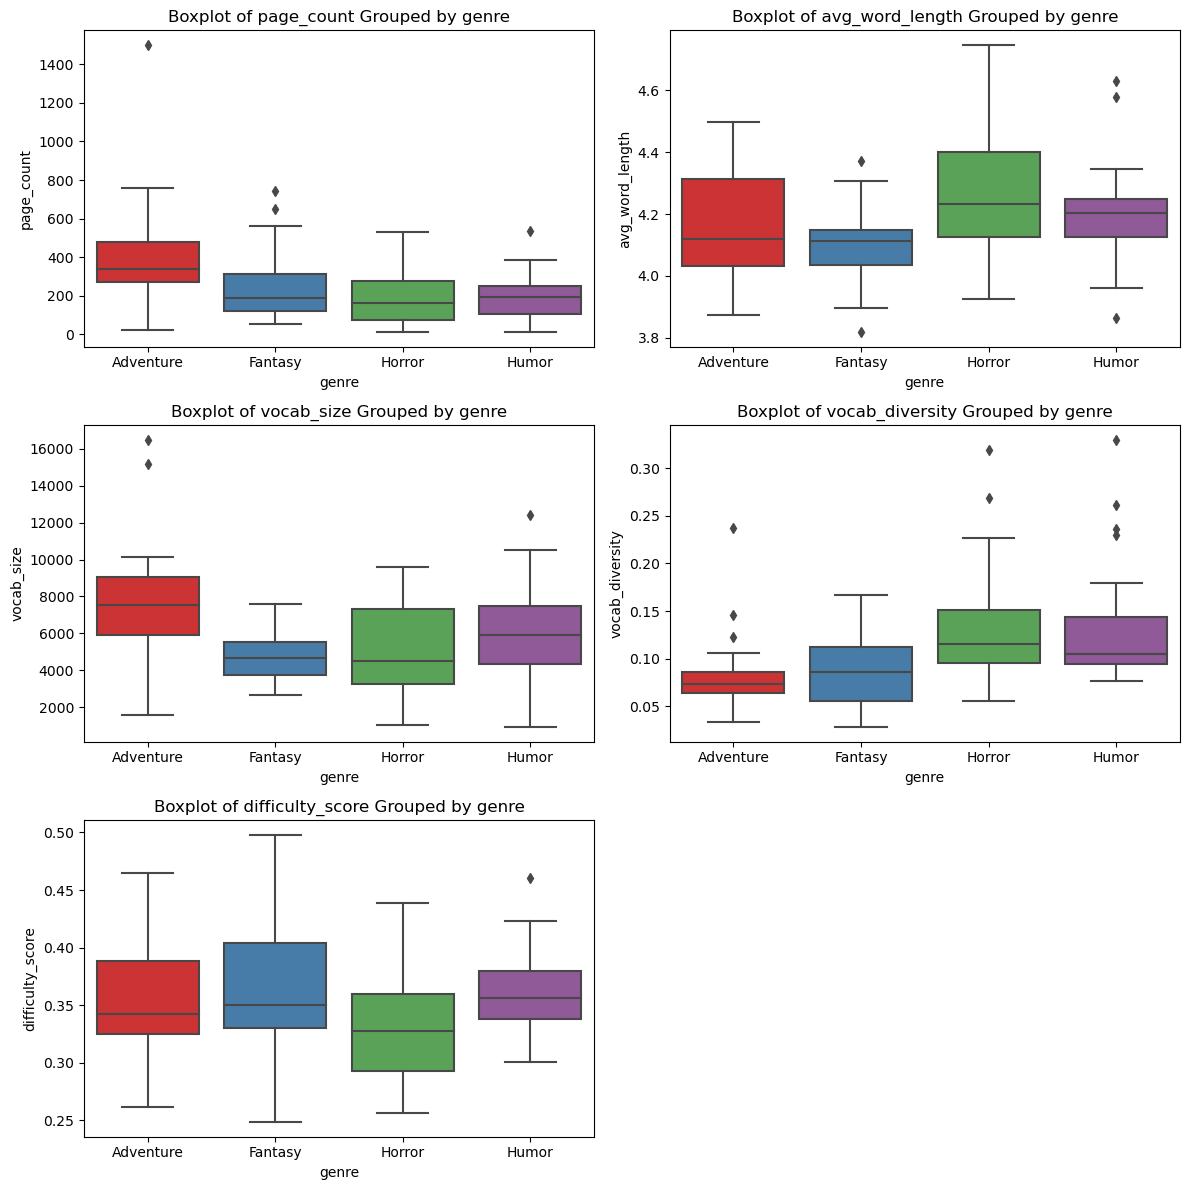

In [229]:
boxplots(bookdf2, bookdf2.columns[5:], 'genre', 3, 2)

## Sentiment Analysis

In [271]:
# calculate the sentiment polarity for a given piece of text and return it
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [270]:
# this function takes in a text file for a given novel, calculates the sentiment for 100 equal 
# parts of the novel, then returns a dictionary of the list of 100 sentiment scores, as well
# as the the average overall sentiment
def book_sentiment(file):
    with open(file, 'r', encoding='utf-8') as f:
        text = f.read()
    # separate the novel into 100 equal parts
    part_length = len(text) // 100
    parts = [text[i:i+part_length] for i in range(0, len(text), part_length)][:100]
    # generate a list of sentiment scores for each of these parts
    sentiment_scores = [calculate_sentiment(part) for part in parts]
    # calculate overall average sentiment
    average_sentiment = sum(sentiment_scores) / len(sentiment_scores)
    # return the resulting dictionary
    return {
        'sentiment_scores': sentiment_scores,
        'average_sentiment': average_sentiment
    }

In [272]:
# this function takes in a list of sentiment values, then returns the percentage that are above 0
def pct_positive(nums):
    pos = 0
    for num in nums:
        if num > 0:
            pos += 1
    return pos / len(nums)

In [273]:
# generate the list of sentiment value dictionaries for each novel and add it to a list
sentiment_list = list()
for i, row in bookdf2.iterrows():
    f, g = row.filename, row.genre
    sent = book_sentiment(directory_stem + g + '/' + f)
    sent['filename'] = f
    sentiment_list.append(sent)

In [274]:
# create a third df to hold these new values for the sake of creating a checkpoint
bookdf3 = bookdf2.copy()

In [275]:
# add the sentiment values for the new dataframe
bookdf3['average_sentiment'] = [x['average_sentiment'] for x in sentiment_list]
bookdf3['pct_pos_sentiment'] = [pct_positive(x['sentiment_scores']) for x in sentiment_list]

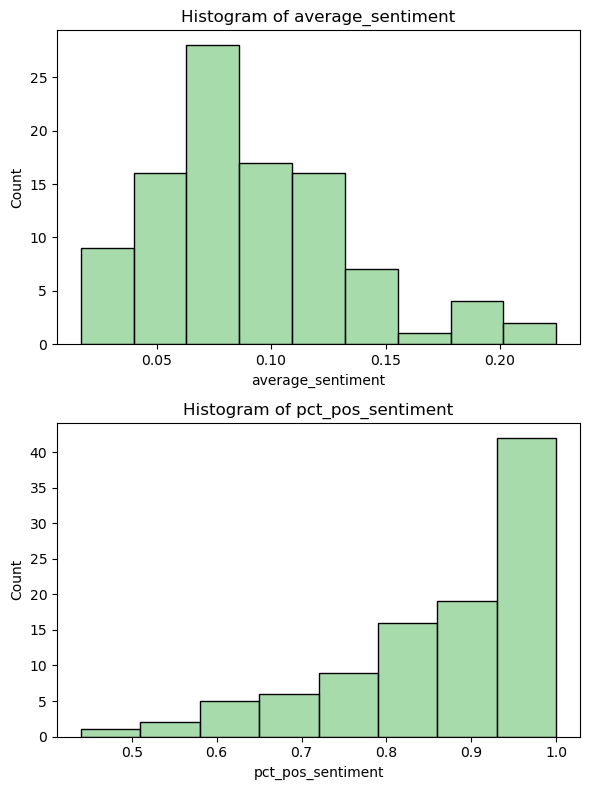

In [300]:
basic_histograms(bookdf3, ['average_sentiment', 'pct_pos_sentiment'], 2, 1, (6,8))

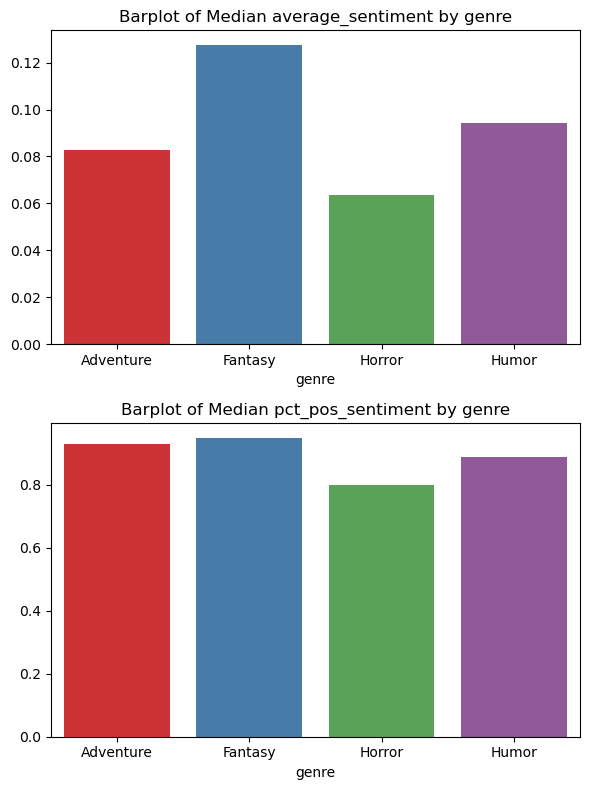

In [301]:
median_barplots(bookdf3, ['average_sentiment', 'pct_pos_sentiment'], 'genre', 2, 1, (6,8))

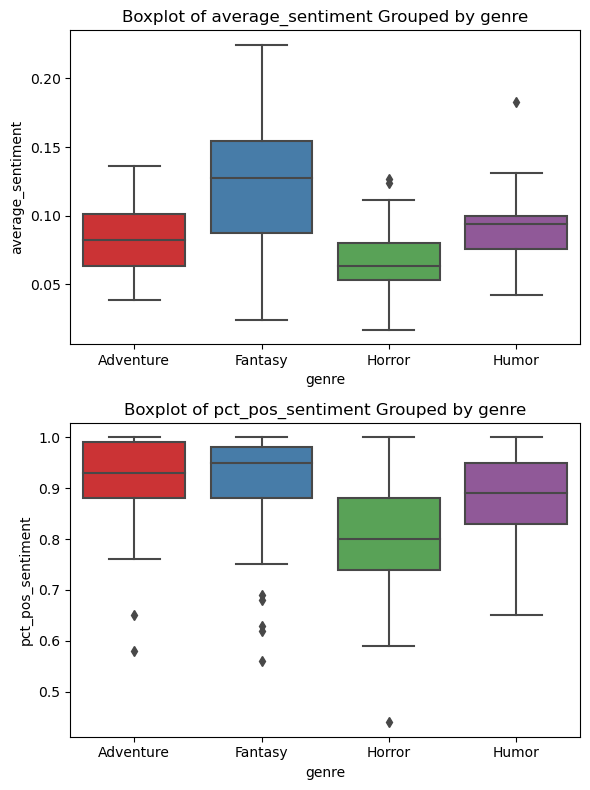

In [302]:
boxplots(bookdf3, ['average_sentiment', 'pct_pos_sentiment'], 'genre', 2, 1, (6,8))

In [279]:
# create a dictionary that contains the filenames for each novel as a key, with the list of 100 sentiment
# scores as the value for each key
sent_dict = dict()
for item in sentiment_list:
    f, scores = item['filename'], item['sentiment_scores']
    sent_dict[f] = scores
# turn the dictionary into a dataframe
sentdf = pd.DataFrame(sent_dict)

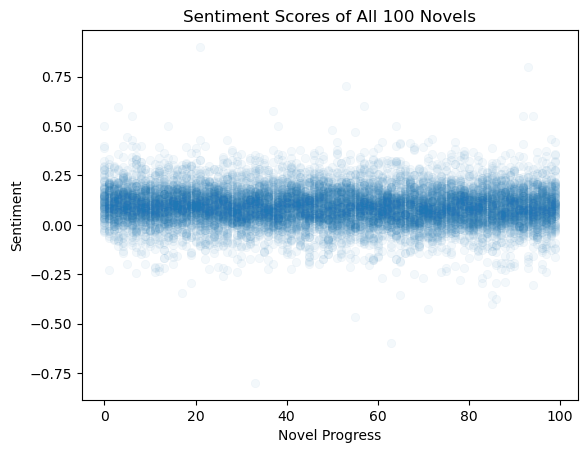

In [288]:
# melt the dataframe down and plot every single sentiment score onto the same scatterplot 
melted_sent = sentdf.reset_index().melt(id_vars='index', var_name='Book', value_name='Sentiment')
sns.scatterplot(data=melted_sent, x='index', y='Sentiment', alpha=0.05, edgecolor=None)
plt.title('Sentiment Scores of All 100 Novels')
plt.xlabel('Novel Progress')
plt.ylabel('Sentiment')
plt.show()

In [551]:
# list some of the quintessential books for each of the four genres
archetypes = ['Moby-Dick; or, The Whale by Herman Melville.txt', 
        'In the Court of King Arthur by Samuel E. Lowe.txt', 
        'Metamorphosis by Franz Kafka.txt', 
        'The Clicking of Cuthbert by P. G. Wodehouse.txt']

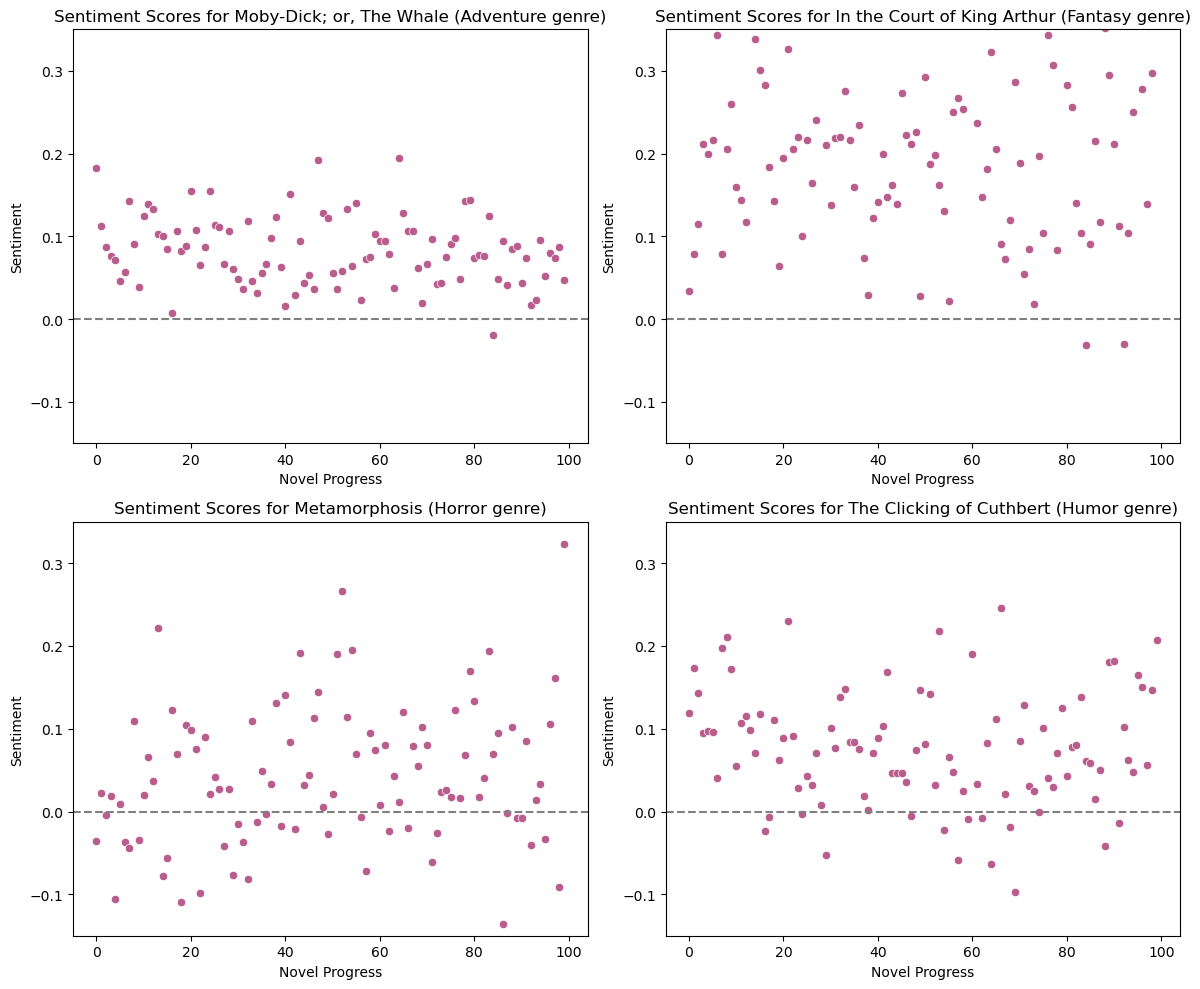

In [552]:
# create a 2x2 plot
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax = ax.flatten() 
# for each of the quintessential novels, plot the scatterplot of sentiment scores
for i, col in enumerate(archetypes):
    data = sentdf[col]
    match = bookdf3[bookdf3.filename == col]
    title, genre = match.iloc[0].title, match.iloc[0].genre
    # when plotting the scatterplot, add a horizontal line to denote the divider between 
    # positive and negative sentiment
    sns.scatterplot(x=data.index, y=data.values, color='#b95d8d', ax=ax[i])
    ax[i].axhline(y=0, color='gray', linestyle='--')
    ax[i].set_ylim((-0.15, 0.35))
    ax[i].set_title(f'Sentiment Scores for {title} ({genre} genre)')
    ax[i].set_xlabel('Novel Progress')
    ax[i].set_ylabel('Sentiment')
plt.tight_layout()
plt.show()

## Correlation Among Variables

In [329]:
# generate a list of the columns that we would like to find correlations of
corr_cols = ['genre'] + list(bookdf3.columns[5:])
# convert genres to dummy variables
corrdf = pd.get_dummies(bookdf3[corr_cols])
# get the correlation chart
corr_overall = corrdf.corr()

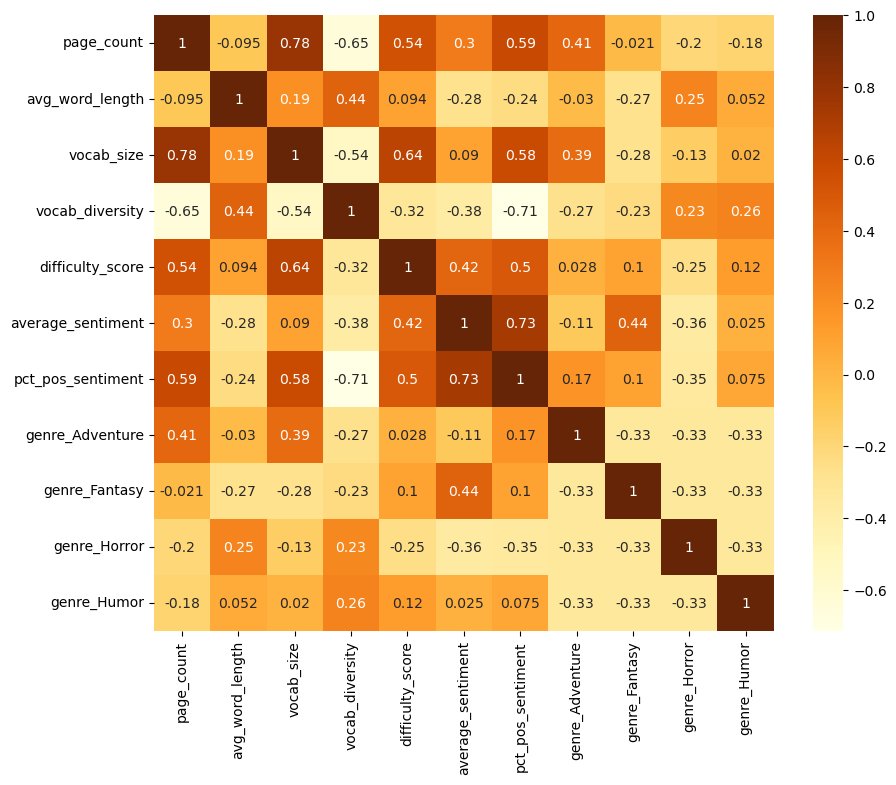

In [405]:
# plot the correlation diagram as a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_overall, annot=True, cmap='YlOrBr')
plt.show()

## Logistic Regression

In [450]:
# get the features and target variables ready for analysis
features = bookdf3[corr_cols].drop(columns='genre')
target = bookdf3['genre']
# split the data into a 70/30 training and testing set
xtrain, xtest, ytrain, ytest = train_test_split(features, target, test_size=0.32, stratify=target, random_state=1)

In [451]:
# this function fits a logistic regression model to the training set, then compares the results to the 
# test set and prints them out
def logistic_regression_model():
    # initiate a standard scaler
    scaler = StandardScaler()
    # transform and fit the scaled training data
    xtrain_scaled = scaler.fit_transform(xtrain)
    xtest_scaled = scaler.transform(xtest)
    # generate the logistic regression model and fit it to the scaled training data
    lrm = LogisticRegression(max_iter=1000)
    lrm.fit(xtrain_scaled, ytrain)
    # create a prediction
    pred = lrm.predict(xtest_scaled)
    # print out the precision, recall and f-1 scores
    print(classification_report(ytest, pred))
    # print out a confusion matrix for the model's accuracy
    cm = confusion_matrix(ytest, pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lrm.classes_)
    display.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

              precision    recall  f1-score   support

   Adventure       0.80      0.50      0.62         8
     Fantasy       0.75      0.38      0.50         8
      Horror       0.50      0.75      0.60         8
       Humor       0.64      0.88      0.74         8

    accuracy                           0.62        32
   macro avg       0.67      0.62      0.61        32
weighted avg       0.67      0.62      0.61        32



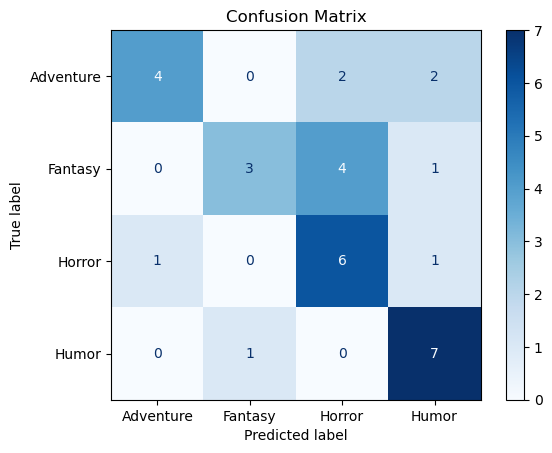

In [452]:
logistic_regression_model()

## Decision Tree

In [458]:
# this function fits a decision tree model to the training set, then compares the results to the 
# test set and prints them out
def decision_tree_model():
    # initiate a decision tree and fit it to the training data
    dtc = DecisionTreeClassifier(max_depth=3)
    dtc.fit(xtrain, ytrain)
    pred = dtc.predict(xtest)
    # print out the classification report
    print(classification_report(ytest, pred))
    # plot a visualization of the decision tree bifurcations
    plt.figure(figsize=(30,15))
    tree.plot_tree(dtc, filled=True, feature_names=list(features.columns), class_names=genres)
    plt.show()
    # print out the confusion matrix for the model's accuracy
    cm = confusion_matrix(ytest, pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
    display.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

              precision    recall  f1-score   support

   Adventure       0.67      0.75      0.71         8
     Fantasy       0.67      0.25      0.36         8
      Horror       0.40      0.75      0.52         8
       Humor       0.20      0.12      0.15         8

    accuracy                           0.47        32
   macro avg       0.48      0.47      0.44        32
weighted avg       0.48      0.47      0.44        32



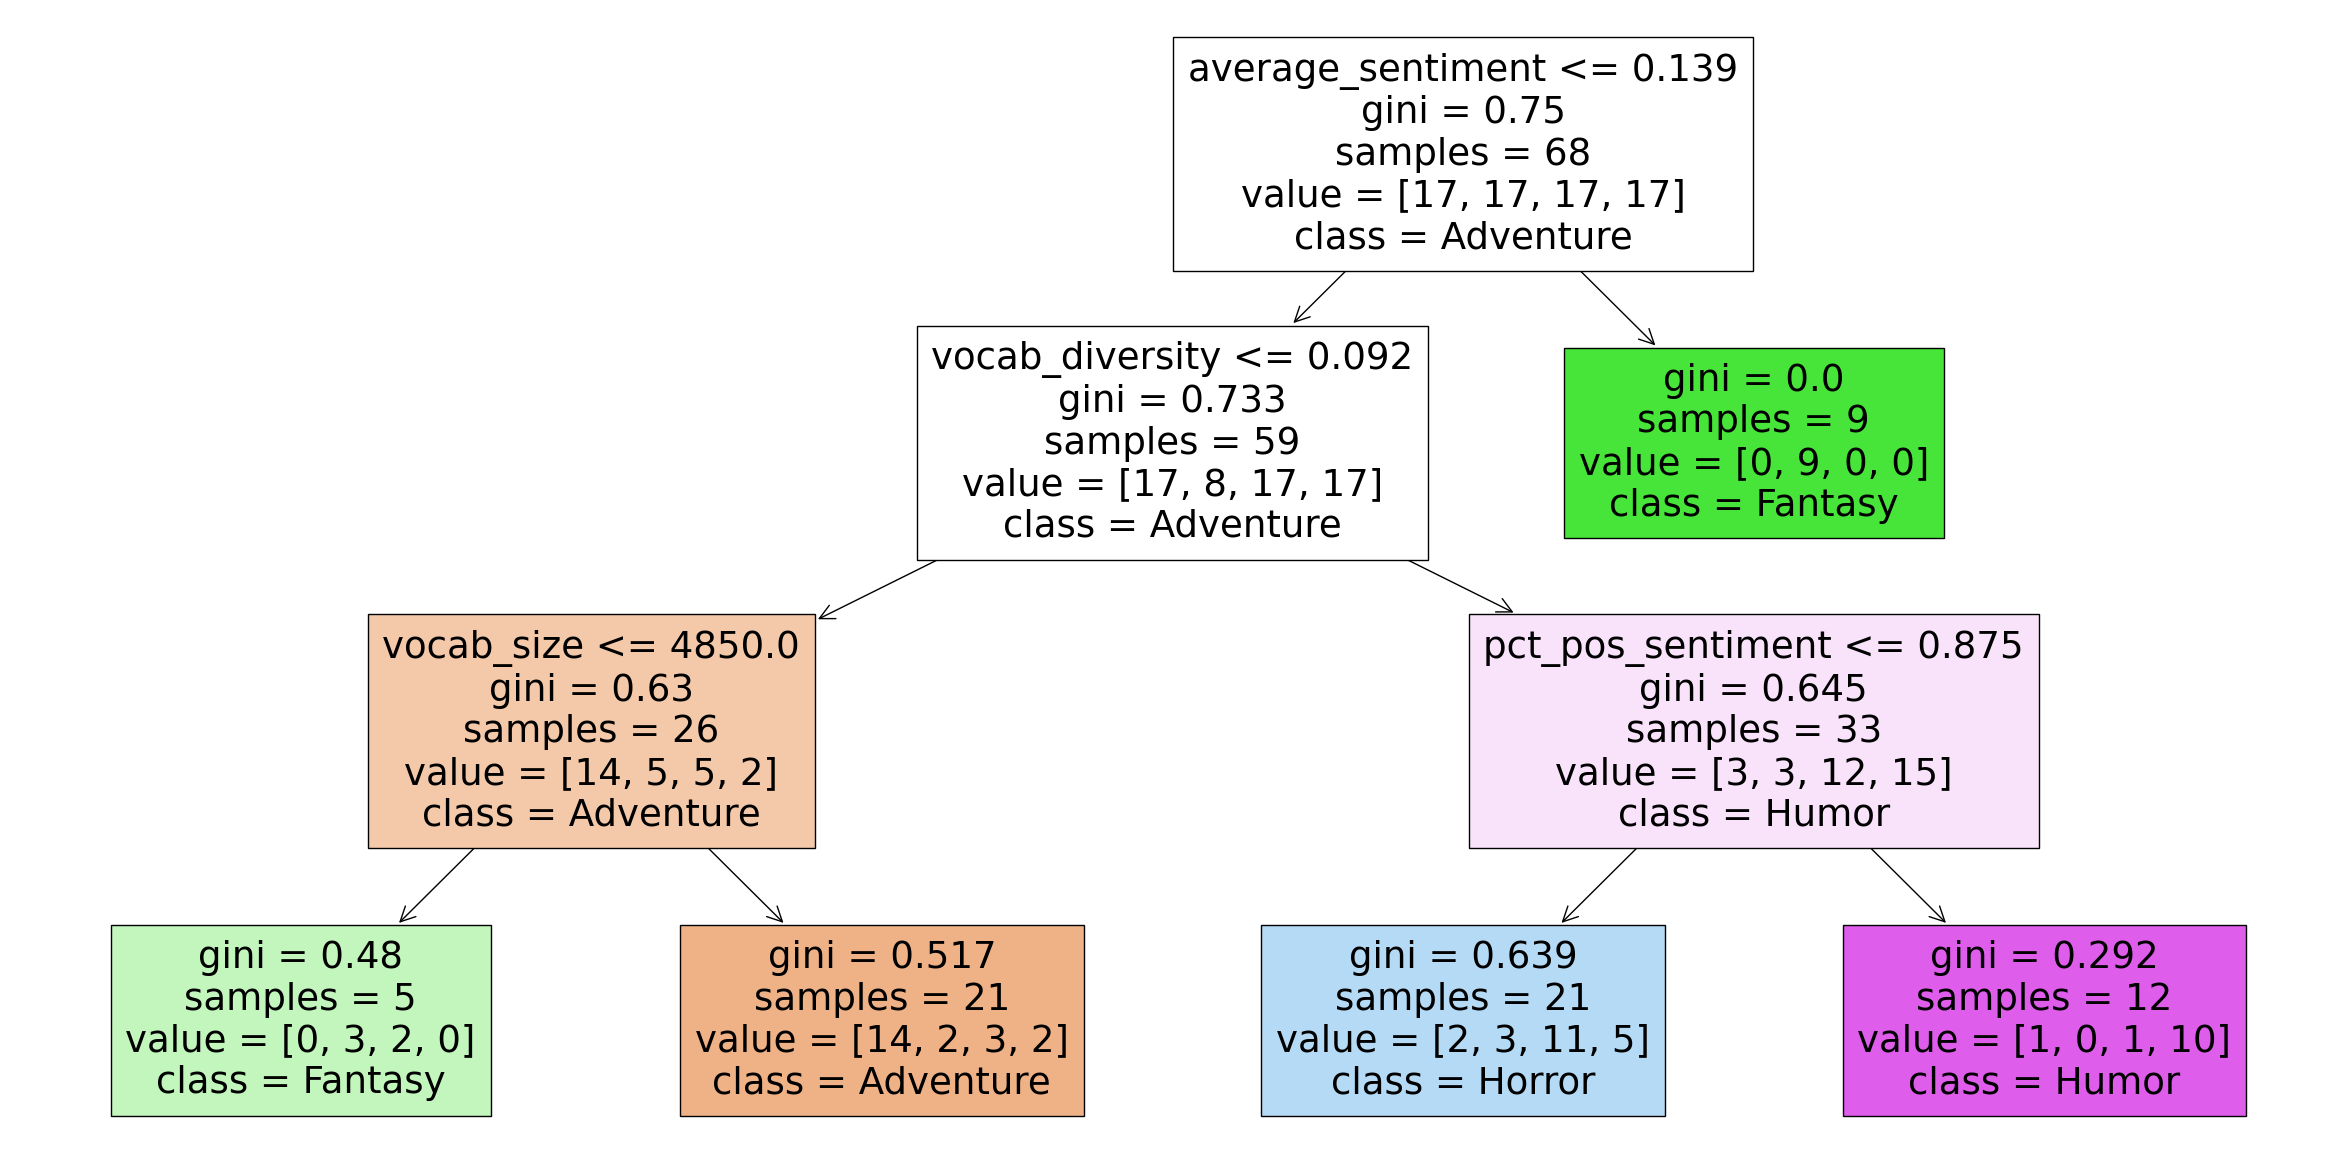

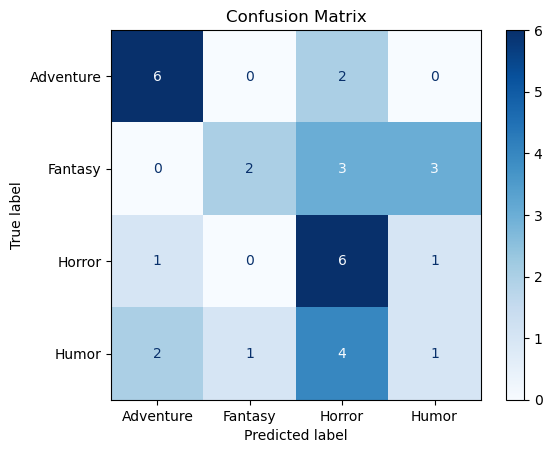

In [459]:
decision_tree_model()

## Ensemble Model

In [501]:
# this function fits a voting classifier ensemble model of the decision tree and logistic regression model,
# then compares the results to the test set and prints them out
def voting_ensemble():
    # scale the training data for consistency between the two models
    scaler = StandardScaler()
    xtrain_scaled = scaler.fit_transform(xtrain)
    xtest_scaled = scaler.transform(xtest)
    # generate the logistic regression model
    lrm = LogisticRegression(max_iter=1000)
    lrm.fit(xtrain_scaled, ytrain)
    # now generate the decision tree model
    dtc = DecisionTreeClassifier(max_depth=3)
    dtc.fit(xtrain_scaled, ytrain)
    # create the ensemble model as a voting classifier ensemble, which is more 
    # heavily weighted towards the logistic regression model
    ensemble = VotingClassifier(estimators=[('logistic', lrm), ('tree', dtc)], 
                                voting='soft', weights=[2,1])  
    # fit the data to the ensemble model and make the predictions
    ensemble.fit(xtrain_scaled, ytrain)
    pred = ensemble.predict(xtest_scaled)
    # print the classification report
    print(classification_report(ytest, pred))
    # print the confusion matrix of the model's accuracy
    cm = confusion_matrix(ytest, pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lrm.classes_)
    display.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

              precision    recall  f1-score   support

   Adventure       0.80      0.50      0.62         8
     Fantasy       1.00      0.25      0.40         8
      Horror       0.40      0.75      0.52         8
       Humor       0.50      0.62      0.56         8

    accuracy                           0.53        32
   macro avg       0.68      0.53      0.52        32
weighted avg       0.68      0.53      0.52        32



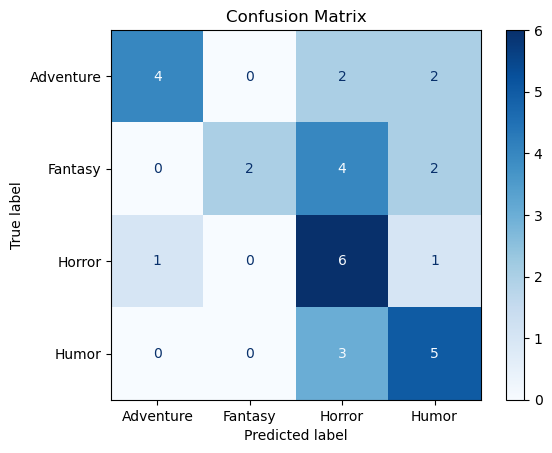

In [502]:
voting_ensemble()

## K-Means Clustering

In [526]:
# this function generates a set of four clusters using the k-means algorithm on the book data
# it returns a df of the titles, genre, and the cluster it belongs to
def kmeans(n=4):
    # scale the data and fit
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(features)
    # run the k-means algorithm to generate the clusters
    kmc = KMeans(n_clusters=n, n_init=10, random_state=1)
    kmc.fit(scaled_data)
    clusters = kmc.predict(scaled_data)
    # add these values to a dataframe
    result = features.copy()
    result['title'], result['genre'] = bookdf3['title'], bookdf3['genre']
    result['cluster'] = clusters
    # return the df
    return result

In [527]:
kmdf = kmeans()

In [529]:
# group the number of novels belonging to each genre within each of the generated clusters
cdata = kmdf.groupby('cluster').genre.value_counts(normalize=True)

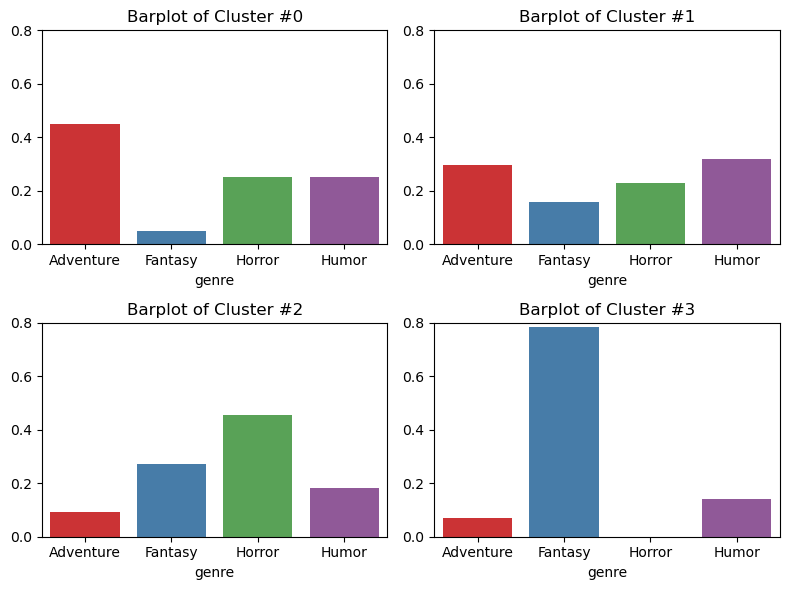

In [547]:
# plot a barplot for each of the clusters, with the x-axis as the genre, and the y-axis as the percentage of 
# books contained within that genre
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))
ax = ax.flatten()
for i in range(4):
    sns.barplot(x=cdata[i].index, y=cdata[i].values, ax=ax[i], order=genres, palette='Set1')
    ax[i].set_title(f'Barplot of Cluster #{i}')
    ax[i].set_ylim(0,0.8)
plt.tight_layout()
plt.show()

In [546]:
kmdf.cluster.value_counts().sort_index()

cluster
0    20
1    44
2    22
3    14
Name: count, dtype: int64